**Описание задачи**

Добро пожаловать в 2912 год, где ваши навыки работы с данными необходимы для разгадки космической тайны. Мы получили сообщение с расстояния четырех световых лет. Информация крайне тревожная… Звучит интригующе, неправда ли?

В этот раз вам предстоит попробовать себя в роли исследователя в составе команды game development. Разработчики MMORPG игры Lost-in-space обратилась к вам со следующей проблемой… В ходе игры пользователям предстоит выполнять путешествия в космическом пространстве, иногда они могут попасть в пространственно-временную аномалию, скрытую в облаке пыли. По сценарию игры не все игроки должны добраться до пункта назначения, в связи с этим разработчики заложили в игру алгоритм, ограничивающий перемещение игрока по определенным критериям. Так как практически все критерии, которые использует их алгоритм игрок может настраивать, наиболее продвинутые игроки могут начать перебирать их (подстраивать персонажа и условия транспортировки) для того, чтобы повысить свои шансы на успешное перемещение.

Вас попросили разработать и обучить модель машинного обучения, которая по табличным данным предсказывает, какие игроки были перенесены аномалией, используя данные, которые могут собрать пользователи в ходе игры. Так же необходимо выделить наиболее значимые признаки, которые больше всего влияют на вероятность успешного перехода. Это позволит оценить надежность работы алгоритма и устойчивость его к взлому со стороны пользователей игры.

Для полноты картины на соседней вкладке представлено краткое описание этапа игры, в котором игрокам предстоит выполнить межзвездный переход, на пути которого возникает аномалия.

**Этапы проекта**

В этом проекте вам предстоит пройти все этапы полноценного исследования:

- загрузка и ознакомление с данными,
- подготовка данных,
- разведочный анализ,
- feature engineering and feature extraction,
- подготовка итоговых признаков для обучения модели,
- обучение модели и формирование предсказаний,
- изучение важности признаков итоговой модели,
- подготовка отсчета по исследованию.
Проект будет проходить в виде соревнования на платформе Kaggle - одном из самых известных ресурсов среди дата-саентистов. Так вы сможете сравнить полученные результаты с результатами ваших одногруппников и поучаствовать в своём первом DS соревновании!

# Читаем данные 

In [1]:
#%pip install category_encoders
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, KBinsDiscretizer, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn import set_config
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

In [3]:
sample_submission = pd.read_csv('D:/gamedev_competition/sample_submission.csv')
test = pd.read_csv('D:/gamedev_competition/test.csv')
train = pd.read_csv('D:/gamedev_competition/train.csv')

In [4]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  1739 non-null   object
 1   Transported  1739 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 15.4+ KB


In [5]:
#test.profile_report()

In [6]:
#train.profile_report()

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6791 non-null   object 
 2   CryoSleep     6784 non-null   object 
 3   Cabin         6798 non-null   object 
 4   Destination   6813 non-null   object 
 5   Age           6811 non-null   float64
 6   VIP           6798 non-null   object 
 7   RoomService   6812 non-null   float64
 8   FoodCourt     6810 non-null   float64
 9   ShoppingMall  6792 non-null   float64
 10  Spa           6809 non-null   float64
 11  VRDeck        6807 non-null   float64
 12  Name          6794 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 13 columns):
 #   Column        Non-Null Count  

In [8]:
train.columns = ['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination', 'age', 'vip', 'room_service',
                'food_court', 'shopping_mall', 'spa', 'vr_deck', 'name', 'transported']
test.columns = ['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination', 'age', 'vip', 'room_service',
               'food_court', 'shopping_mall', 'spa', 'vr_deck', 'name']

In [9]:
train

,passenger_id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name,transported
0,6234_01,Mars,False,F/1287/P,PSO J318.5-22,40.0,True,301.0,0.0,1310.0,4.0,NaN,Sters Bun,True
1,8826_01,Europa,False,C/290/P,55 Cancri e,13.0,False,1212.0,4485.0,0.0,4016.0,57.0,Marin Hednigic,False
2,4453_01,Europa,False,D/149/P,TRAPPIST-1e,28.0,False,0.0,2560.0,0.0,134.0,307.0,Azhasim Inguel,False
3,0602_03,Mars,True,F/125/P,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,0.0,0.0,Rana Brine,True
4,8796_01,Earth,False,G/1418/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Daisya Traverdy,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,1182_02,Mars,False,E/70/P,TRAPPIST-1e,24.0,False,2997.0,0.0,3.0,0.0,7.0,Wee Pota,True
6950,3396_01,Europa,True,B/106/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Acruxon Mirinanty,True
6951,1161_02,Europa,False,B/48/S,55 Cancri e,19.0,False,0.0,1291.0,0.0,16139.0,687.0,Mirfark Anderking,False
6952,6921_06,Europa,False,C/255/S,TRAPPIST-1e,32.0,False,0.0,89.0,0.0,8330.0,1.0,Azhah Stersetery,False


In [10]:
test

,passenger_id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name
0,8026_01,Mars,True,F/1534/S,TRAPPIST-1e,29.0,False,0.0,0.0,0.0,0.0,0.0,Losp Ruité
1,6734_03,Europa,True,C/249/S,55 Cancri e,37.0,True,0.0,0.0,0.0,0.0,0.0,Alhaino Sparsaxle
2,8186_04,Earth,True,G/1319/S,PSO J318.5-22,23.0,False,0.0,0.0,0.0,0.0,0.0,Rayley Jenkinnedy
3,4942_02,Earth,True,G/806/S,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,Coreee Reenon
4,8640_01,Earth,False,F/1666/S,NaN,50.0,False,133.0,0.0,525.0,0.0,31.0,Diandy Hurchrisong
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,5589_01,Earth,False,F/1160/P,TRAPPIST-1e,26.0,False,0.0,786.0,0.0,11.0,83.0,Fayen Hermanapp
1735,8229_01,Earth,True,G/1336/P,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Armene Patthews
1736,2234_03,Mars,False,E/134/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,Apench Flité
1737,0253_01,Earth,False,G/42/P,TRAPPIST-1e,29.0,False,272.0,615.0,0.0,0.0,1.0,Dawne Cardner


In [11]:
train.isna().mean() * 100

passenger_id     0.000000
home_planet      2.343975
cryo_sleep       2.444636
cabin            2.243313
destination      2.027610
age              2.056370
vip              2.243313
room_service     2.041990
food_court       2.070751
shopping_mall    2.329594
spa              2.085131
vr_deck          2.113891
name             2.300834
transported      0.000000
dtype: float64

In [12]:
test.isna().mean() * 100

passenger_id     0.000000
home_planet      2.185164
cryo_sleep       2.702703
cabin            2.472685
destination      2.357677
age              2.070155
vip              2.702703
room_service     2.242668
food_court       2.242668
shopping_mall    2.645198
spa              2.185164
vr_deck          2.357677
name             2.300173
dtype: float64

In [13]:
print(f'Duplicates in train : {train.duplicated().sum()}')
print(f'Duplicates in test : {test.duplicated().sum()}')

Duplicates in train : 0
Duplicates in test : 0


In [14]:
train.describe()

,age,room_service,food_court,shopping_mall,spa,vr_deck
count,6811.000000,6812.000000,6810.000000,6792.000000,6809.000000,6807.000000
mean,28.758773,219.851879,458.781791,173.162691,302.198120,305.534156
std,14.370668,649.921373,1601.377860,598.108352,1120.863112,1148.581726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,42.000000,70.750000,24.000000,56.000000,45.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [15]:
test.describe()

,age,room_service,food_court,shopping_mall,spa,vr_deck
count,1703.000000,1700.000000,1700.000000,1693.000000,1701.000000,1698.000000
mean,29.104521,244.064706,455.254706,176.001772,346.927690,302.131331
std,14.954129,730.040047,1651.850705,630.612402,1197.700925,1134.492838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,62.000000,93.000000,36.000000,92.000000,47.000000
max,79.000000,14327.000000,27071.000000,10705.000000,16594.000000,17074.000000


In [16]:
colors = sns.color_palette('pastel')
sns.set(rc={'figure.figsize':(15, 5)}, palette=colors) #Задам настройки таблиц

<AxesSubplot:>

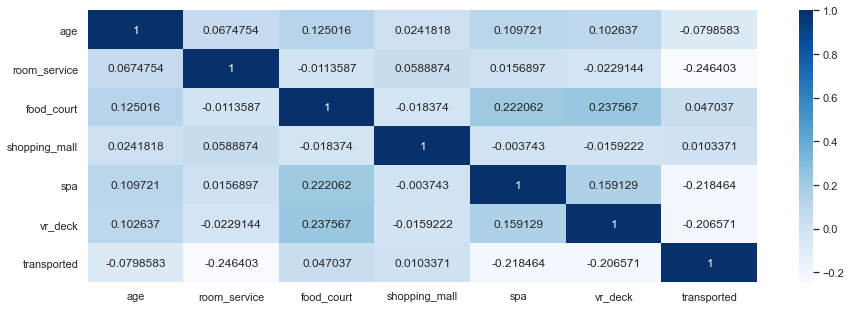

In [17]:
sns.heatmap(train.corr(), annot=True, cmap='Blues', fmt='g')

In [18]:
#sns.pairplot(train.select_dtypes(exclude=['object']), hue='transported')

В таблице присутствуют немногочисленные пропуски в каждом столбце. У нас есть столбцы с категориальными значениями, там пропуски я заменю на значение 'unknown'. Булевы значения заполню в соответствии со значениями в соседних столбцах. В численных столбцах у нас нет дискретных значений. Их заполню с помощью KNNImputer.

Дубликатов нет, классы сбалансированы. В численных столбцах наибольшая корреляция с ЦП наблюдается с `room_service`, `spa`, `vr_deck`. Категориальные признаки изучим в дальнейшем. Возможно, имеет смысл сделать категоризацию по возрасту, чтобы усилить корреляцию. Колонки `cabin` и `name` отбросим за неинформативностью на этапе подготовки к обучению. Также, по уже имеющимся сведениям, видно, что ВИП-статус используют немногие игроки. Из `cabin` можно извлечь некоторую информацию.

# Исследовательский анализ

In [19]:
def plots(name, column):
    sns.barplot(data=train, x=column, y='transported')
    plt.title(name, fontweight="bold")
    plt.show()

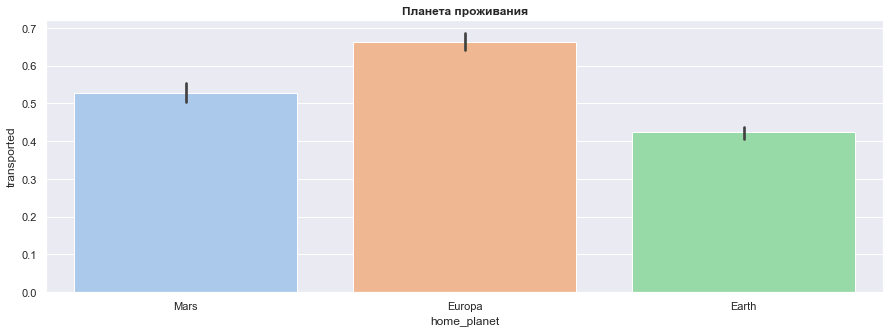

In [20]:
plots('Планета проживания', 'home_planet')

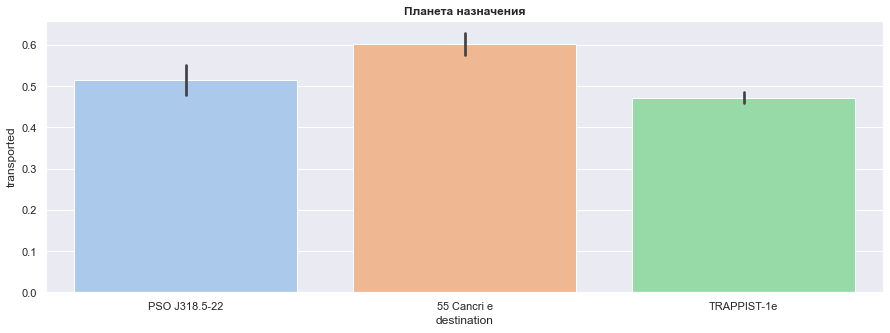

In [21]:
plots('Планета назначения', 'destination')

Чаще всего переносятся аномалией пассажиры родом с Европы, следующие на 55 Cancri e.

In [22]:
def count_obj_features(column):
    sns.countplot(x=column, hue='transported', data=train)
    plt.title('Соотношение признаков ' + column + ' по отношению к целевому', fontweight='bold')
    plt.show()

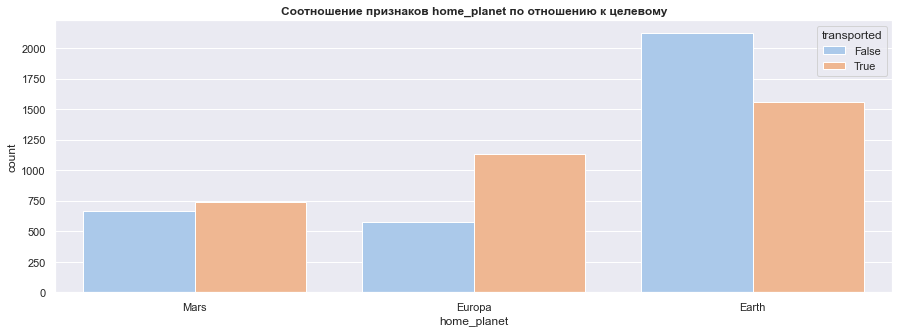

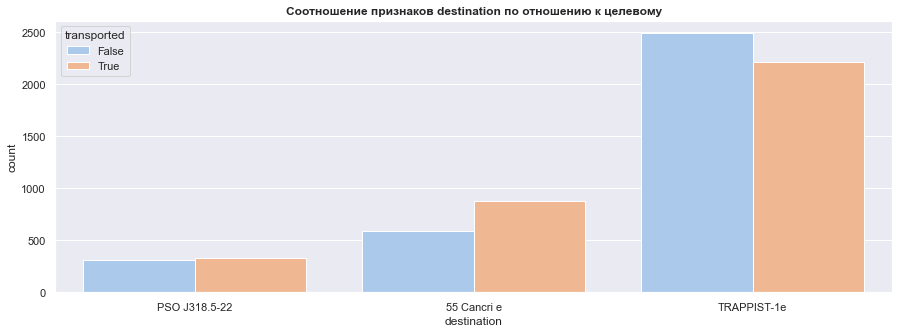

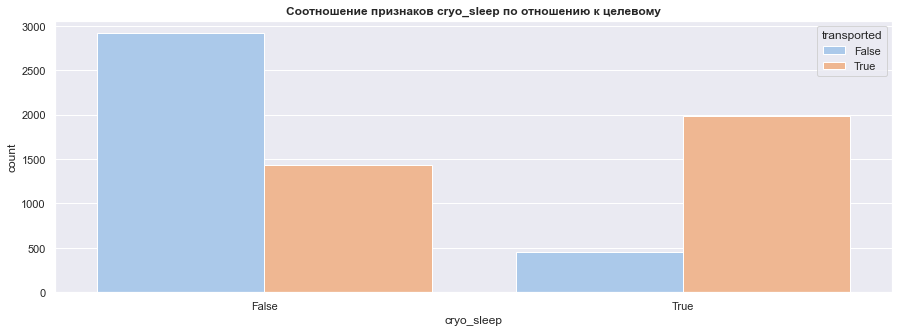

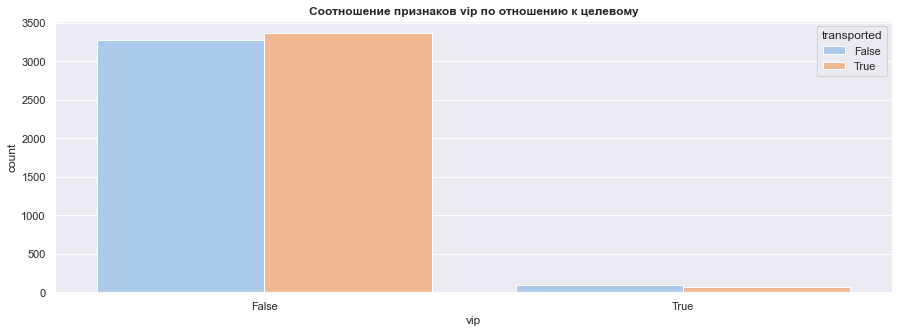

In [23]:
cols = ['home_planet', 'destination', 'cryo_sleep', 'vip']
for col in cols:
    count_obj_features(col)

Как видим, наиболее четко категории выражены у признака `cryo_sleep` и `home_planet`. Остальные не выделяют четко какой то признак.

<AxesSubplot:xlabel='age', ylabel='Density'>

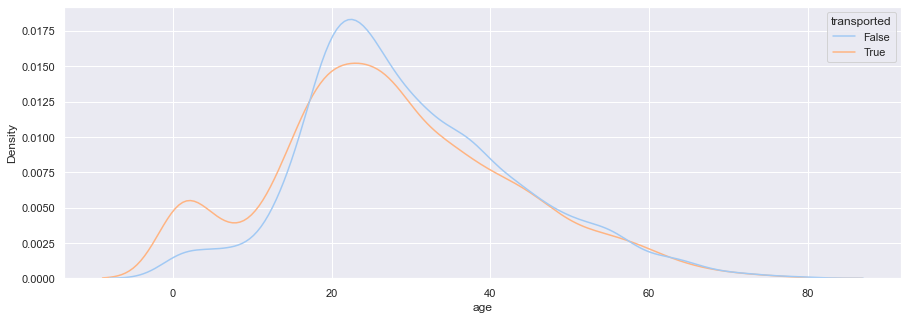

In [24]:
sns.kdeplot(data=train, x='age', hue='transported')

In [25]:
def distribution(name, column):
    sns.boxplot(train.loc[train[column] != 0, column])
    plt.title(name, fontsize=18, fontweight='bold')
    plt.show()

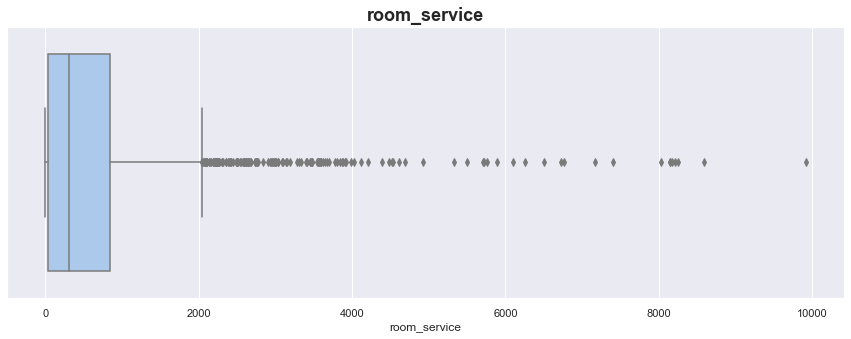

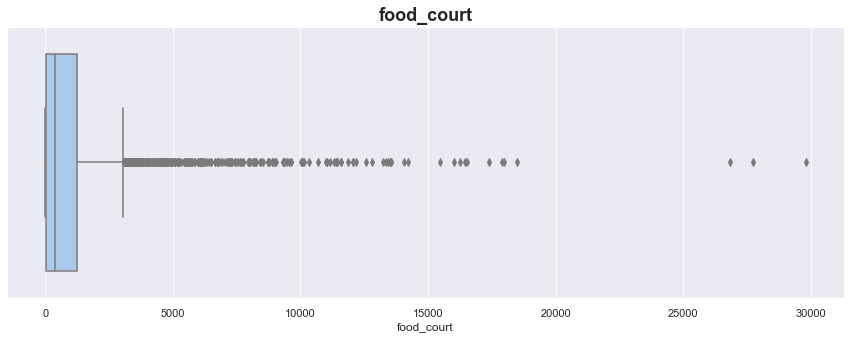

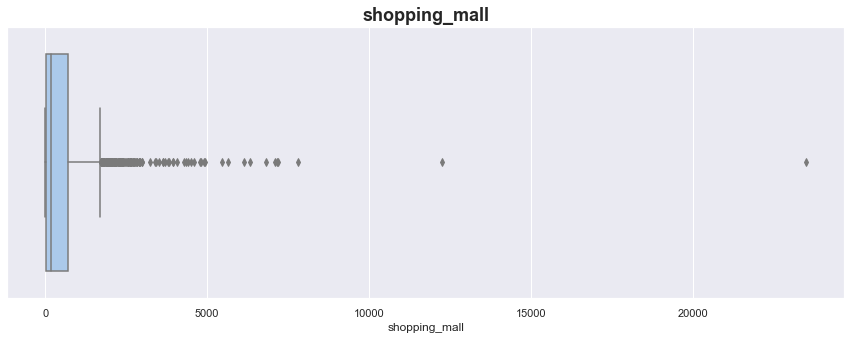

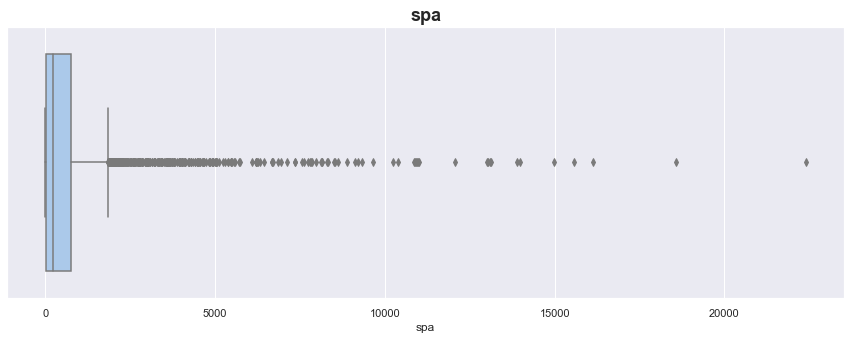

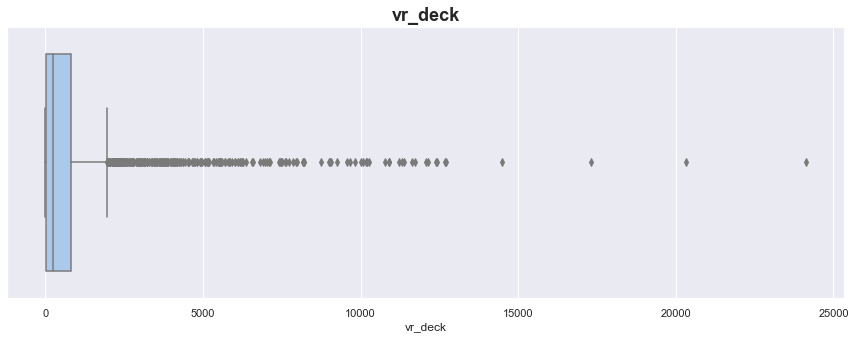

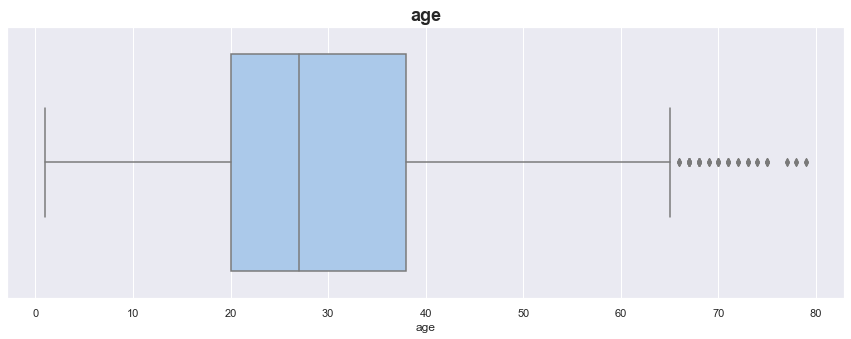

In [26]:
cols = ['room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck', 'age']
for column in cols:
    distribution(column, column)

В вышеозначенных столбцах замечено множество выбросов даже если отбросить моду.

<AxesSubplot:>

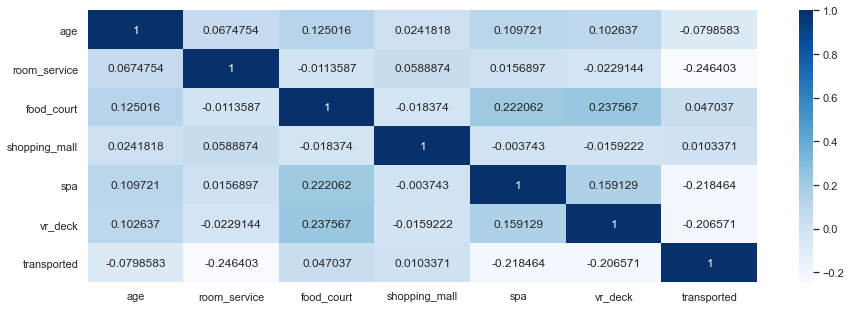

In [27]:
sns.heatmap(train.corr(), annot=True, cmap='Blues', fmt='g') #Еще раз посмотрим на зависимости

In [28]:
#Проверил, что все значения услуг по нулям у тех, кто выбрал крио сон
train.loc[train['cryo_sleep'] == 1, ['room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']].describe()

,room_service,food_court,shopping_mall,spa,vr_deck
count,2377.0,2377.0,2355.0,2377.0,2389.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


**Выводы, сделанные на основе исследовательского анализа:**
- Чаще всего геймеры стартуют с планеты `Europa` и приземляются на планету `55 Cancri e`. Пропуски в этих признаках в принципе уравновешены по целевому. Так что было правильным решением пометить их как `unknown`.
- Игроки до 18 лет чаще попадают в аномалию. 
- Признак `cryo_sleep` очень сильно смещен по ЦП. Это значит, что это один из наиболее важных признаков в нашем обучении.
- Признак `vip`, напротив, не вызывает интереса, в обучении мы его отбросим. Остальные категориальные признаки оставим, зависимости с ЦП прослеживаются.
- В непрерывных признаках заметны выбросы, которые нужно будет удалить.
- `vr_deck`, `spa` и `room_service` сильно коррелируют с ЦП.

# Подготовка данных к обучению

В ходе исследований мы выяснили, что колонка `vip` не дает результата и слабо коррелирует с ЦП. Ее мы включать в обучающий датасет не будем.

In [29]:
features, target = train[['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination',
                           'age', 'room_service', 'food_court', 'shopping_mall', 'spa',
                           'vr_deck', 'name']], train['transported']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=1)
features_to_submit = test[['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination',
                           'age', 'room_service', 'food_court', 'shopping_mall', 'spa',
                           'vr_deck', 'name']]

In [30]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passenger_id   6954 non-null   object 
 1   home_planet    6791 non-null   object 
 2   cryo_sleep     6784 non-null   object 
 3   cabin          6798 non-null   object 
 4   destination    6813 non-null   object 
 5   age            6811 non-null   float64
 6   room_service   6812 non-null   float64
 7   food_court     6810 non-null   float64
 8   shopping_mall  6792 non-null   float64
 9   spa            6809 non-null   float64
 10  vr_deck        6807 non-null   float64
 11  name           6794 non-null   object 
dtypes: float64(6), object(6)
memory usage: 652.1+ KB


In [31]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self, df):
        trans_df = df.copy(deep=True)
        trans_df['team'] = trans_df['passenger_id'].str.extract(r'(\d+)_', expand=False).astype('int')
        trans_df['in_team'] = trans_df['team'].duplicated(keep=False).astype('int')
        trans_df.drop(columns=['team'], inplace=True)
        
        trans_df[['deck', 'side']] = trans_df['cabin'].str.extract(r'([A-Z]+)/[0-9]+/([PS])', expand=True)
        trans_df['deck'] = trans_df['deck'].apply(lambda x: x if x in ['A', 'B', 'C', 'D', 'E', 'F', 'G'] else np.nan)
        
        services = ['room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']
        trans_df.loc[trans_df['cryo_sleep'] == 1, services] = [0] * 5
        trans_df.loc[((trans_df['cryo_sleep'].isna()) & (np.sum((trans_df[services] == 0), axis=1) < 5)), 'cryo_sleep'] = 0
        trans_df.loc[((trans_df['cryo_sleep'].isna()) & (np.sum((trans_df[services] == 0), axis=1) == 5)), 'cryo_sleep'] = 1
        trans_df['cryo_sleep'] = trans_df['cryo_sleep'].astype('int')
        
        trans_df.drop(columns=['passenger_id', 'cabin', 'name'], inplace=True)
        return trans_df
   
    def fit(self, df, y=None):
        return self

In [32]:
pp = PreProcessing()

In [33]:
cat_cols = ['home_planet', 'destination', 'deck', 'side']
numeric_cols = ['age', 'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="unknown"),
    ce.TargetEncoder()
)

transformer = ColumnTransformer([('num_imputer', KNNImputer(n_neighbors=5), numeric_cols), 
                                 ('cat_imputer', cat_pipe, cat_cols)],
                                 remainder='passthrough')
#transformer.set_output(transform="pandas")

In [34]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, df):
        df = pd.DataFrame(df, columns=['age', 'room_service', 'food_court', 'shopping_mall',
                         'spa', 'vr_deck', 'home_planet', 'destination', 'deck', 'side', 'cryo_sleep', 'in_team'])
        df['summ'] = df.room_service + df.food_court + df.shopping_mall + df.spa + df.vr_deck
        df['coef'] = (df.spa + df.vr_deck + df.room_service) / (df.summ)
#        df['age_category'] = df['age'].apply(lambda x: 1 if x < 19 else 0)
        df['coef'] = df['coef'].fillna(0)
        df.drop(columns='in_team', inplace=True)
        return df
    def fit(self, df, y=None):
        return self

In [35]:
feature_engineering = FeatureEngineering()

In [36]:
pipeline_rf = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering), 
                        ('scaler', StandardScaler()),
                        ('estimator', RandomForestClassifier(random_state=1))    
]
)

In [37]:
pipeline_gbc = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering),
                        ('scaler', StandardScaler()),
                        ('estimator', GradientBoostingClassifier(random_state=1))    
]
)

In [38]:
pipeline_dt = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering),
                        ('scaler', StandardScaler()),
                        ('estimator', DecisionTreeClassifier(random_state=1))    
]
)

In [39]:
pipeline_knn = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering),
                        ('scaler', PowerTransformer()),
                        ('estimator', KNeighborsClassifier())
]
)

In [40]:
pipeline_lr = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering),
                        ('scaler', MinMaxScaler()),
                        ('estimator', LogisticRegression(random_state=1))    
]
)

In [41]:
pipeline_lgbm = Pipeline([('preprocessor', pp),
                        ('transformer', transformer),
                        ('features', feature_engineering),
                        ('scaler', MinMaxScaler()),
                        ('estimator', LGBMClassifier(random_state=1))    
]
)

In [42]:
pipeline_rf

Pipeline(steps=[('preprocessor', PreProcessing()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_imputer', KNNImputer(),
                                                  ['age', 'room_service',
                                                   'food_court',
                                                   'shopping_mall', 'spa',
                                                   'vr_deck']),
                                                 ('cat_imputer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder())]),
                                                  ['home_planet', 'destination',
                                                   'deck', 'side'])])),
                ('features', FeatureEngineering()),
                ('scaler', StandardScaler()),
                ('estimator', RandomForestClassifier(random_state=1))])

# Обучение

In [43]:
#Строим функцию для постройки ROC-AUC графика
def rocauc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
def results(model, features, target):
    prediction = model.predict(features)
    proba_one = model.predict_proba(features)[:, 1]
    fpr, tpr, threshold = roc_curve(target, proba_one)
    rocauc(fpr, tpr)
    print("Accuracy:", round(accuracy_score(target, prediction), 3))
    print("F1:", round(f1_score(target, prediction), 3))
    print("ROC_auc:", round(roc_auc_score(target, proba_one), 3))
    print("Precision:", round(precision_score(target, prediction), 3))
    print("Recall:", round(recall_score(target, prediction), 3))

In [44]:
#Делаем функцию для того, чтобы смотреть на важность признаков
def feature_importances(model):
    pd.Series(model['estimator'].feature_importances_,
             ['age', 'room_service', 'food_court', 'shopping_mall',
              'spa', 'vr_deck', 'home_planet', 'destination', 'deck',
              'side', 'cryo_sleep', 'summ', 'coef']).sort_values().plot(kind='barh')
    plt.title('Важность признаков')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    plt.tight_layout()
    plt.show()

In [45]:
def cross_val_plot(model, features, target):
    plt.plot(cross_val_score(model, features, target, cv=5, scoring='accuracy', n_jobs=-1))
    plt.title('Показатели CV')
    plt.xlabel('CV')
    plt.ylabel('Accuracy')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show()

In [46]:
sampler = TPESampler(seed=10)

## Random Forest

In [46]:
def objective(trial):
    params = {
    'estimator__criterion' : trial.suggest_categorical('criterion', ['entropy']),
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'estimator__max_depth' : trial.suggest_int('max_depth', 1, 15),
    'estimator__min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20, 2)
    }
    pipeline = pipeline_rf.set_params(**params)
    pipeline.fit(features_train, target_train)
    
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()  
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200, callbacks=[callback])
model_rf = study.user_attrs["best_booster"]
print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-01 20:06:24,063] A new study created in memory with name: no-name-074e96ab-69aa-48aa-a0de-6dbfdf1cde35
[I 2023-03-01 20:06:26,566] Trial 0 finished with value: 0.7470810952316315 and parameters: {'criterion': 'entropy', 'n_estimators': 78, 'max_depth': 1, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.7470810952316315.
[I 2023-03-01 20:06:28,319] Trial 1 finished with value: 0.7925565746863426 and parameters: {'criterion': 'entropy', 'n_estimators': 75, 'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7925565746863426.
[I 2023-03-01 20:06:29,638] Trial 2 finished with value: 0.7938175066415869 and parameters: {'criterion': 'entropy', 'n_estimators': 20, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7938175066415869.
[I 2023-03-01 20:06:30,734] Trial 3 finished with value: 0.7878850019714687 and parameters: {'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 11, 'min_samples_leaf': 20}. Best is trial 2 with value: 0.7

[I 2023-03-01 20:07:02,175] Trial 34 finished with value: 0.7963322603372827 and parameters: {'criterion': 'entropy', 'n_estimators': 80, 'max_depth': 9, 'min_samples_leaf': 6}. Best is trial 28 with value: 0.7983095464329344.
[I 2023-03-01 20:07:03,410] Trial 35 finished with value: 0.7961514346474303 and parameters: {'criterion': 'entropy', 'n_estimators': 85, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 28 with value: 0.7983095464329344.
[I 2023-03-01 20:07:04,729] Trial 36 finished with value: 0.7983098696245161 and parameters: {'criterion': 'entropy', 'n_estimators': 94, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:05,926] Trial 37 finished with value: 0.7914792155493935 and parameters: {'criterion': 'entropy', 'n_estimators': 94, 'max_depth': 12, 'min_samples_leaf': 20}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:07,081] Trial 38 finished with value: 0.7981301751051989 and paramet

[I 2023-03-01 20:07:41,252] Trial 69 finished with value: 0.795433787740697 and parameters: {'criterion': 'entropy', 'n_estimators': 83, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:42,496] Trial 70 finished with value: 0.7920184607031355 and parameters: {'criterion': 'entropy', 'n_estimators': 93, 'max_depth': 12, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:43,608] Trial 71 finished with value: 0.7900411746074838 and parameters: {'criterion': 'entropy', 'n_estimators': 88, 'max_depth': 9, 'min_samples_leaf': 18}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:44,902] Trial 72 finished with value: 0.7983093848371438 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:07:46,134] Trial 73 finished with value: 0.7948940577995824 and paramet

[I 2023-03-01 20:08:22,806] Trial 104 finished with value: 0.7930958198400849 and parameters: {'criterion': 'entropy', 'n_estimators': 78, 'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:08:23,983] Trial 105 finished with value: 0.7975906067598751 and parameters: {'criterion': 'entropy', 'n_estimators': 85, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:08:25,196] Trial 106 finished with value: 0.7959730328944391 and parameters: {'criterion': 'entropy', 'n_estimators': 89, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:08:26,577] Trial 107 finished with value: 0.797590606759875 and parameters: {'criterion': 'entropy', 'n_estimators': 99, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:08:27,756] Trial 108 finished with value: 0.7950739139146904 and param

[I 2023-03-01 20:09:04,405] Trial 138 finished with value: 0.7963312907625382 and parameters: {'criterion': 'entropy', 'n_estimators': 98, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:09:05,659] Trial 139 finished with value: 0.7941756029138953 and parameters: {'criterion': 'entropy', 'n_estimators': 96, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:09:06,945] Trial 140 finished with value: 0.7983093848371438 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:09:08,222] Trial 141 finished with value: 0.7983093848371438 and parameters: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.7983098696245161.
[I 2023-03-01 20:09:09,568] Trial 142 finished with value: 0.7979498342027187 and par

[I 2023-03-01 20:09:48,334] Trial 172 finished with value: 0.7948942193953732 and parameters: {'criterion': 'entropy', 'n_estimators': 94, 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 158 with value: 0.7984892409522517.
[I 2023-03-01 20:09:49,615] Trial 173 finished with value: 0.7984892409522517 and parameters: {'criterion': 'entropy', 'n_estimators': 96, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 158 with value: 0.7984892409522517.
[I 2023-03-01 20:09:50,861] Trial 174 finished with value: 0.7984892409522517 and parameters: {'criterion': 'entropy', 'n_estimators': 96, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 158 with value: 0.7984892409522517.
[I 2023-03-01 20:09:52,120] Trial 175 finished with value: 0.7984892409522517 and parameters: {'criterion': 'entropy', 'n_estimators': 96, 'max_depth': 9, 'min_samples_leaf': 4}. Best is trial 158 with value: 0.7984892409522517.
[I 2023-03-01 20:09:53,298] Trial 176 finished with value: 0.7952532852424261 and pa

Accuracy: 0.7984892409522517 с параметрами: {'criterion': 'entropy', 'n_estimators': 96, 'max_depth': 9, 'min_samples_leaf': 4}


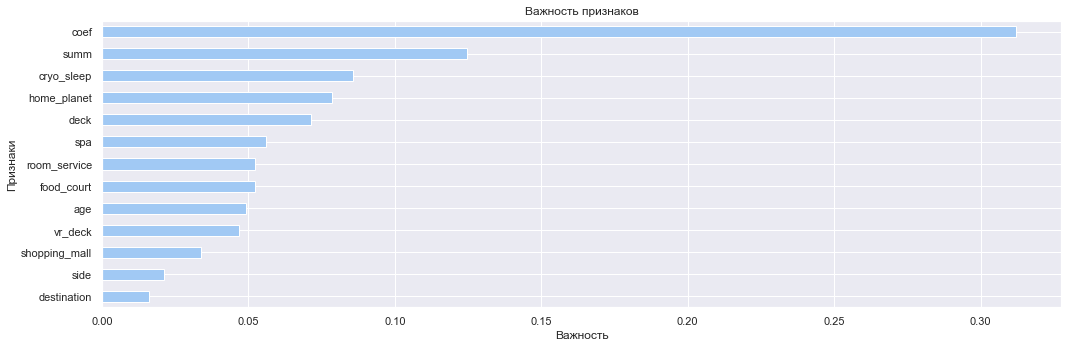

In [47]:
feature_importances(model_rf)

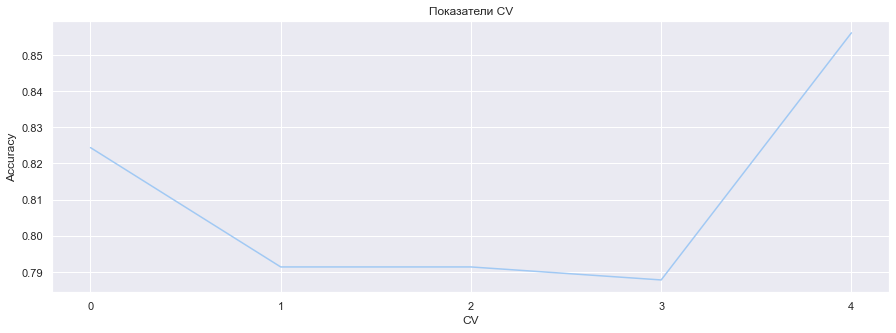

In [48]:
cross_val_plot(model_rf, features_test, target_test)

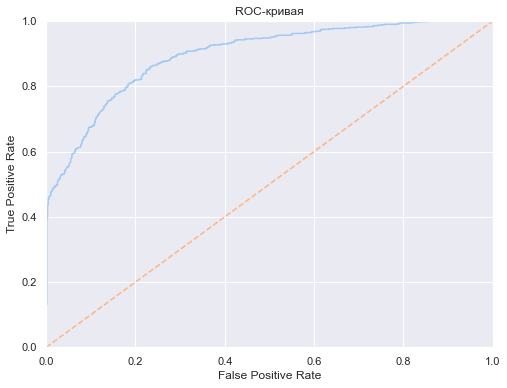

Accuracy: 0.807
F1: 0.814
ROC_auc: 0.806
Precision: 0.807
Recall: 0.82


In [49]:
results(model_rf, features_test, target_test)

In [50]:
prediction_rf = model_rf.predict(features_to_submit)

## KNN

In [51]:
def objective(trial):
    params = {
    'estimator__algorithm' : trial.suggest_categorical('algorithm', ['ball_tree','kd_tree', 'brute']),
    'estimator__n_neighbors' : trial.suggest_int('n_neighbors', 10, 30)
    }
    pipeline = pipeline_knn.set_params(**params)
    pipeline.fit(features_train , target_train)
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, callbacks=[callback])
model_knn = study.user_attrs["best_booster"]
print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-01 20:10:22,090] A new study created in memory with name: no-name-5da6ccb9-f058-4c4f-8be6-bf750cb83534
[I 2023-03-01 20:10:22,706] Trial 0 finished with value: 0.7717052234223403 and parameters: {'algorithm': 'brute', 'n_neighbors': 16}. Best is trial 0 with value: 0.7717052234223403.
[I 2023-03-01 20:10:23,333] Trial 1 finished with value: 0.7772794702243596 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27}. Best is trial 1 with value: 0.7772794702243596.
[I 2023-03-01 20:10:23,972] Trial 2 finished with value: 0.7772794702243596 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 27}. Best is trial 1 with value: 0.7772794702243596.
[I 2023-03-01 20:10:24,593] Trial 3 finished with value: 0.7772799550117319 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 25}. Best is trial 3 with value: 0.7772799550117319.
[I 2023-03-01 20:10:25,214] Trial 4 finished with value: 0.7763798664572386 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13}. Best is tri

[I 2023-03-01 20:10:47,936] Trial 41 finished with value: 0.7821315454375044 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:10:48,559] Trial 42 finished with value: 0.7751205504599016 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 18}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:10:49,231] Trial 43 finished with value: 0.7783584453192163 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 21}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:10:49,905] Trial 44 finished with value: 0.7778177458033573 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 17}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:10:50,532] Trial 45 finished with value: 0.7736838022843181 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 22}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:10:51,157] Trial 46 finished with value: 0.77440

[I 2023-03-01 20:11:14,369] Trial 82 finished with value: 0.7744032267447498 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 20}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:11:15,005] Trial 83 finished with value: 0.7751205504599016 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 18}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:11:15,660] Trial 84 finished with value: 0.7783582837234256 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 30}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:11:16,290] Trial 85 finished with value: 0.7821315454375044 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 19}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:11:16,947] Trial 86 finished with value: 0.7726046655936706 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 16}. Best is trial 40 with value: 0.7821315454375044.
[I 2023-03-01 20:11:17,571] Trial 87 finished with value: 0.77566

Accuracy: 0.7821315454375044 с параметрами: {'algorithm': 'kd_tree', 'n_neighbors': 19}


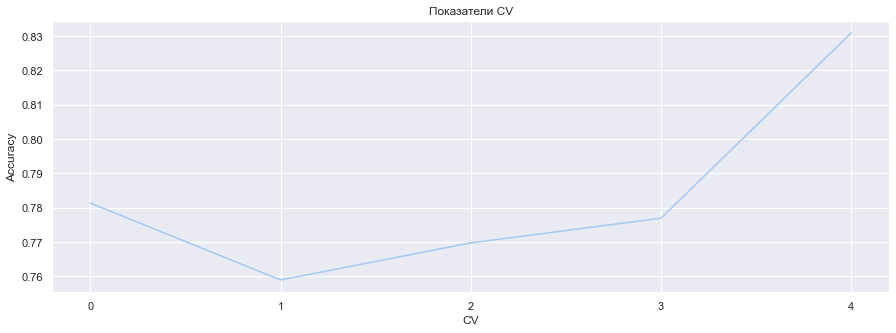

In [52]:
cross_val_plot(model_knn, features_test, target_test)

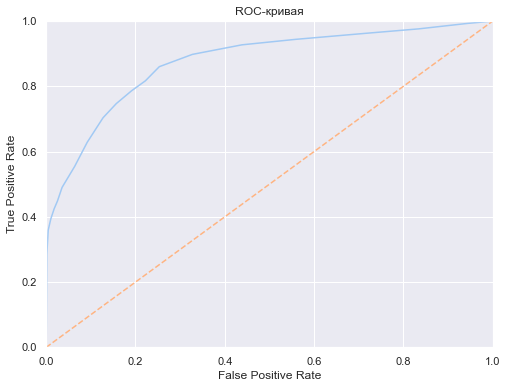

Accuracy: 0.794
F1: 0.789
ROC_auc: 0.795
Precision: 0.835
Recall: 0.747


In [53]:
results(model_knn, features_test, target_test)

In [54]:
prediction_knn = model_knn.predict(features_to_submit)

## Decision Tree

In [55]:
def objective(trial):
    params = {
    'estimator__criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'estimator__max_depth' : trial.suggest_int('max_depth', 2, 20),
    'estimator__min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 20)
    }
    pipline = pipeline_dt.set_params(**params)
    pipline.fit(features_train, target_train)
    trial.set_user_attr(key="best_booster", value=pipline)
    cross_valid = cross_val_score(pipline, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200, callbacks=[callback])
model_dt = study.user_attrs["best_booster"]
print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-01 20:11:26,236] A new study created in memory with name: no-name-cc6ddca6-7b2e-4c0b-bad8-893a06f716df
[I 2023-03-01 20:11:26,748] Trial 0 finished with value: 0.7781781044167362 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7781781044167362.
[I 2023-03-01 20:11:27,216] Trial 1 finished with value: 0.7824951359666983 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.7824951359666983.
[I 2023-03-01 20:11:27,706] Trial 2 finished with value: 0.7684716916493759 and parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.7824951359666983.
[I 2023-03-01 20:11:28,213] Trial 3 finished with value: 0.7832124596818503 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.7832124596818503.
[I 2023-03-01 20:11:28,690] Trial 4 finished with value: 0.77009023508

[I 2023-03-01 20:11:45,185] Trial 38 finished with value: 0.788066474044484 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 24 with value: 0.7911211192770851.
[I 2023-03-01 20:11:45,661] Trial 39 finished with value: 0.7745840524346022 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 15}. Best is trial 24 with value: 0.7911211192770851.
[I 2023-03-01 20:11:46,151] Trial 40 finished with value: 0.7607420801902951 and parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 24 with value: 0.7911211192770851.
[I 2023-03-01 20:11:46,610] Trial 41 finished with value: 0.7900427905653914 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 7}. Best is trial 24 with value: 0.7911211192770851.
[I 2023-03-01 20:11:47,080] Trial 42 finished with value: 0.79076156864266 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 24 with valu

[I 2023-03-01 20:12:03,598] Trial 76 finished with value: 0.788066474044484 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 9}. Best is trial 73 with value: 0.7913011369879837.
[I 2023-03-01 20:12:04,094] Trial 77 finished with value: 0.7837517048355924 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 18}. Best is trial 73 with value: 0.7913011369879837.
[I 2023-03-01 20:12:04,552] Trial 78 finished with value: 0.7868074812387287 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 11}. Best is trial 73 with value: 0.7913011369879837.
[I 2023-03-01 20:12:05,035] Trial 79 finished with value: 0.7907615686426599 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 73 with value: 0.7913011369879837.
[I 2023-03-01 20:12:05,501] Trial 80 finished with value: 0.786267912893405 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 73 with valu

[I 2023-03-01 20:12:21,886] Trial 114 finished with value: 0.7909412631619771 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}. Best is trial 90 with value: 0.7914805083157194.
[I 2023-03-01 20:12:22,375] Trial 115 finished with value: 0.7884255398915367 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1}. Best is trial 90 with value: 0.7914805083157194.
[I 2023-03-01 20:12:22,849] Trial 116 finished with value: 0.7868074812387287 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 90 with value: 0.7914805083157194.
[I 2023-03-01 20:12:23,353] Trial 117 finished with value: 0.7884260246789092 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 90 with value: 0.7914805083157194.
[I 2023-03-01 20:12:23,839] Trial 118 finished with value: 0.7911211192770851 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 90 with va

[I 2023-03-01 20:12:40,168] Trial 152 finished with value: 0.7911211192770851 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:40,742] Trial 153 finished with value: 0.7891444795645962 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:41,237] Trial 154 finished with value: 0.7911211192770851 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:41,709] Trial 155 finished with value: 0.7911211192770851 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:42,172] Trial 156 finished with value: 0.7911211192770851 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}. Best is trial 135 wi

[I 2023-03-01 20:12:58,469] Trial 190 finished with value: 0.7891444795645962 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:58,934] Trial 191 finished with value: 0.7914805083157194 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:59,404] Trial 192 finished with value: 0.7914805083157194 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:12:59,871] Trial 193 finished with value: 0.788246330159592 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3}. Best is trial 135 with value: 0.7918400589501445.
[I 2023-03-01 20:13:00,341] Trial 194 finished with value: 0.7914805083157194 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 135 wit

Accuracy: 0.7918400589501445 с параметрами: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15}


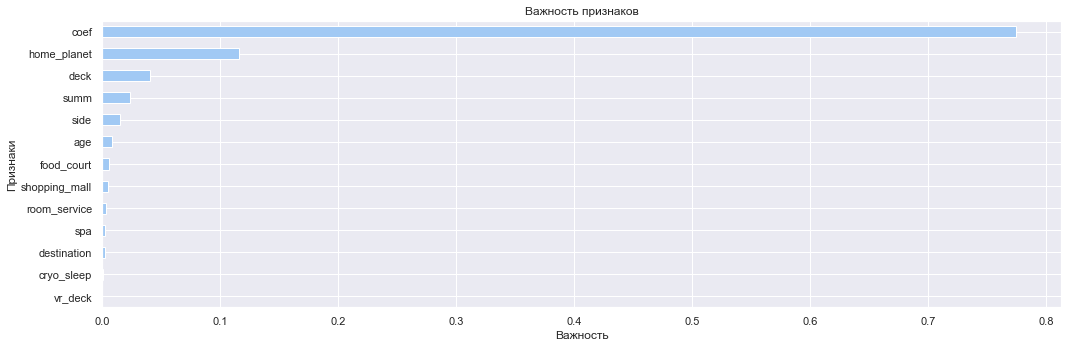

In [56]:
feature_importances(model_dt)

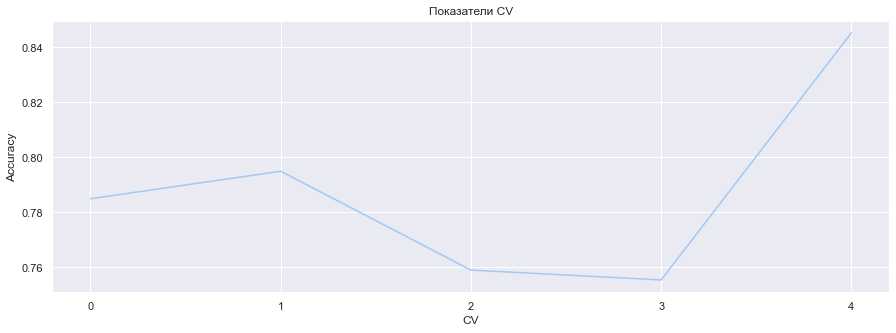

In [57]:
cross_val_plot(model_dt, features_test, target_test)

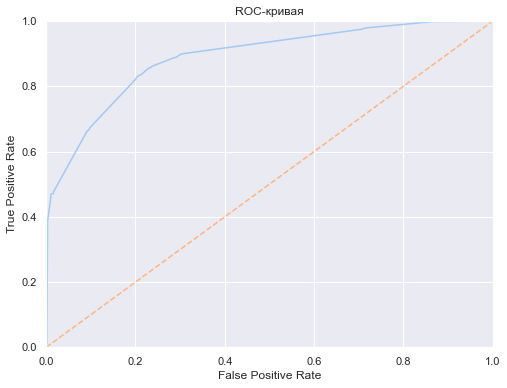

Accuracy: 0.812
F1: 0.821
ROC_auc: 0.812
Precision: 0.806
Recall: 0.837


In [58]:
results(model_dt, features_test, target_test)

In [59]:
prediction_dt = model_dt.predict(features_to_submit)

## Gradient Boosting

In [60]:
def objective(trial):
    params = {
    'estimator__n_estimators' : trial.suggest_int('n_estimators', 1, 100),
    'estimator__max_depth' : trial.suggest_int('max_depth', 1, 15),
    'estimator__learning_rate' : trial.suggest_float('learning_rate', 0.2, 0.8)
    }
    pipeline = pipeline_gbc.set_params(**params)
    pipeline.fit(features_train, target_train)
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200, callbacks=[callback])
model_gbc = study.user_attrs["best_booster"]
print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-01 20:13:03,465] A new study created in memory with name: no-name-cc8957ac-0180-414f-aed6-03d56766d1ec
[I 2023-03-01 20:13:04,886] Trial 0 finished with value: 0.7722436605971288 and parameters: {'n_estimators': 30, 'max_depth': 8, 'learning_rate': 0.6040801551708324}. Best is trial 0 with value: 0.7722436605971288.
[I 2023-03-01 20:13:05,428] Trial 1 finished with value: 0.7904018564124441 and parameters: {'n_estimators': 16, 'max_depth': 1, 'learning_rate': 0.4026895322388077}. Best is trial 1 with value: 0.7904018564124441.
[I 2023-03-01 20:13:06,023] Trial 2 finished with value: 0.7896835631225477 and parameters: {'n_estimators': 11, 'max_depth': 3, 'learning_rate': 0.7314962577006234}. Best is trial 1 with value: 0.7904018564124441.
[I 2023-03-01 20:13:07,032] Trial 3 finished with value: 0.781054994279509 and parameters: {'n_estimators': 37, 'max_depth': 4, 'learning_rate': 0.6514977021311618}. Best is trial 1 with value: 0.7904018564124441.
[I 2023-03-01 20:13:08,163]

[I 2023-03-01 20:13:57,600] Trial 36 finished with value: 0.7939957467987874 and parameters: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.5147114349005117}. Best is trial 14 with value: 0.798850569140375.
[I 2023-03-01 20:13:58,758] Trial 37 finished with value: 0.7778204929318001 and parameters: {'n_estimators': 38, 'max_depth': 5, 'learning_rate': 0.6437695568239038}. Best is trial 14 with value: 0.798850569140375.
[I 2023-03-01 20:13:59,549] Trial 38 finished with value: 0.7929180644702567 and parameters: {'n_estimators': 21, 'max_depth': 4, 'learning_rate': 0.3775896065446767}. Best is trial 14 with value: 0.798850569140375.
[I 2023-03-01 20:14:00,094] Trial 39 finished with value: 0.7889638154705345 and parameters: {'n_estimators': 16, 'max_depth': 1, 'learning_rate': 0.5196379826920121}. Best is trial 14 with value: 0.798850569140375.
[I 2023-03-01 20:14:02,829] Trial 40 finished with value: 0.7815939162416697 and parameters: {'n_estimators': 32, 'max_depth': 13, 'lear

[I 2023-03-01 20:14:38,913] Trial 72 finished with value: 0.7918394125669815 and parameters: {'n_estimators': 12, 'max_depth': 2, 'learning_rate': 0.25258934558965884}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:14:39,468] Trial 73 finished with value: 0.7952555475834965 and parameters: {'n_estimators': 7, 'max_depth': 4, 'learning_rate': 0.3092275117197875}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:14:40,019] Trial 74 finished with value: 0.7952544164129612 and parameters: {'n_estimators': 6, 'max_depth': 4, 'learning_rate': 0.3048813454875897}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:14:40,623] Trial 75 finished with value: 0.7947174336002897 and parameters: {'n_estimators': 6, 'max_depth': 5, 'learning_rate': 0.24221415113279685}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:14:41,189] Trial 76 finished with value: 0.7941781884465475 and parameters: {'n_estimators': 6, 'max_depth': 5, 'lea

[I 2023-03-01 20:15:04,800] Trial 108 finished with value: 0.7968711822994434 and parameters: {'n_estimators': 14, 'max_depth': 3, 'learning_rate': 0.3886096419855936}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:05,409] Trial 109 finished with value: 0.7884244087210017 and parameters: {'n_estimators': 14, 'max_depth': 2, 'learning_rate': 0.38619738880414217}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:06,075] Trial 110 finished with value: 0.793816860258424 and parameters: {'n_estimators': 17, 'max_depth': 3, 'learning_rate': 0.44701501821566486}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:06,874] Trial 111 finished with value: 0.7979519349479985 and parameters: {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.3490458994191743}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:07,547] Trial 112 finished with value: 0.7898626112587019 and parameters: {'n_estimators': 28, 'max_depth':

[I 2023-03-01 20:15:32,173] Trial 144 finished with value: 0.7943565901995384 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_rate': 0.2952948332106074}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:32,907] Trial 145 finished with value: 0.7956138054515955 and parameters: {'n_estimators': 18, 'max_depth': 4, 'learning_rate': 0.28046053909907365}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:33,834] Trial 146 finished with value: 0.7939970395651134 and parameters: {'n_estimators': 29, 'max_depth': 4, 'learning_rate': 0.3112310781973202}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:34,704] Trial 147 finished with value: 0.7932785846794264 and parameters: {'n_estimators': 26, 'max_depth': 4, 'learning_rate': 0.32792999409468426}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:15:35,712] Trial 148 finished with value: 0.7889644618536977 and parameters: {'n_estimators': 28, 'max_depth'

[I 2023-03-01 20:16:03,952] Trial 180 finished with value: 0.789143348394061 and parameters: {'n_estimators': 33, 'max_depth': 2, 'learning_rate': 0.324479271331527}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:16:04,813] Trial 181 finished with value: 0.7938186378121224 and parameters: {'n_estimators': 25, 'max_depth': 4, 'learning_rate': 0.32995713758491035}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:16:05,541] Trial 182 finished with value: 0.7957943079498665 and parameters: {'n_estimators': 19, 'max_depth': 4, 'learning_rate': 0.34710094091197224}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:16:06,305] Trial 183 finished with value: 0.7966914877801263 and parameters: {'n_estimators': 21, 'max_depth': 4, 'learning_rate': 0.2908817170520118}. Best is trial 58 with value: 0.8028057877148417.
[I 2023-03-01 20:16:07,031] Trial 184 finished with value: 0.7927372387804043 and parameters: {'n_estimators': 24, 'max_depth': 

Accuracy: 0.8028057877148417 с параметрами: {'n_estimators': 88, 'max_depth': 3, 'learning_rate': 0.2855491953288729}


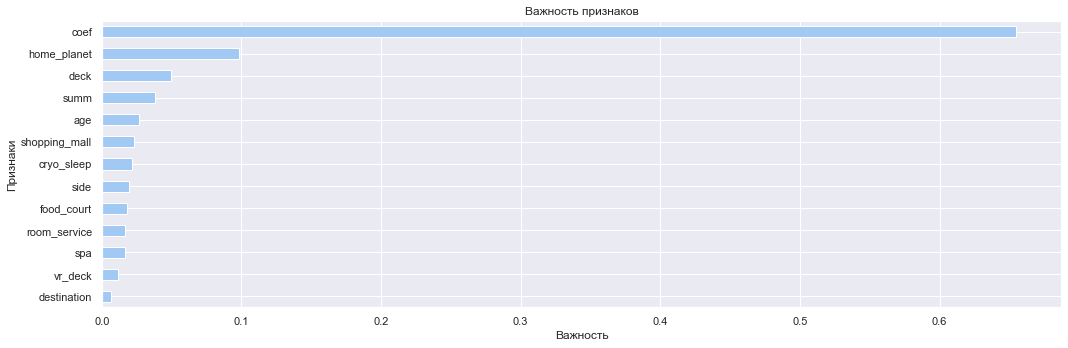

In [61]:
feature_importances(model_gbc)

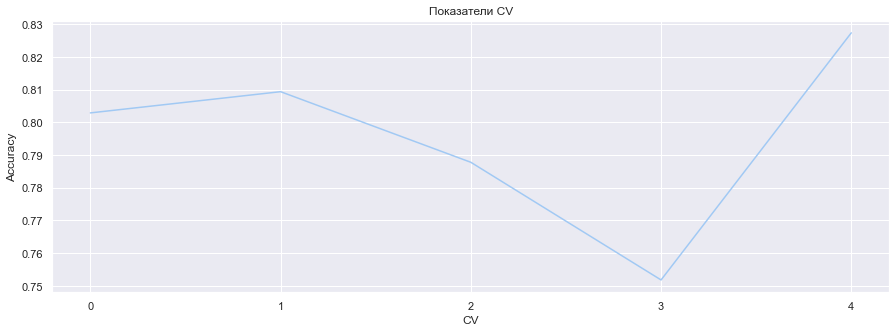

In [62]:
cross_val_plot(model_gbc, features_test, target_test)

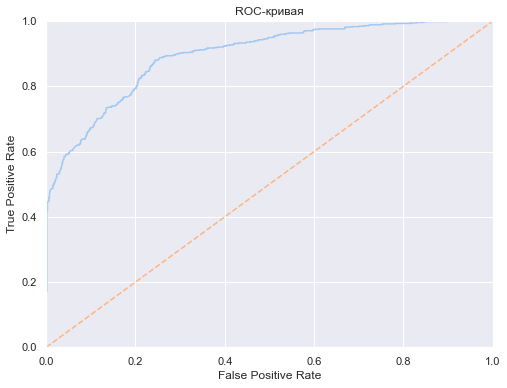

Accuracy: 0.799
F1: 0.804
ROC_auc: 0.799
Precision: 0.808
Recall: 0.8


In [63]:
results(model_gbc, features_test, target_test)

In [64]:
prediction_gbc = model_gbc.predict(features_to_submit)

## Bagging

In [65]:
#def objective(trial): #????????????????????????????????????????????????????????????????????????????????????????????????
#    criterion = trial.suggest_categorical('criterion', ['entropy'])
#    max_depth = trial.suggest_int('max_depth', 1, 15)
#    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, 2)
#    model_rff = DecisionTreeClassifier(random_state=1, criterion=criterion,
#                                     max_depth=max_depth, 
#                                     min_samples_leaf=min_samples_leaf,
#                                     class_weight='balanced'
#                                     )
#    bagging = BaggingClassifier(estimator=model_rff, random_state=1, n_estimators=60)
#    bagging.fit(features_train, target_train)
#    trial.set_user_attr(key="best_booster", value=bagging)
#    cross_valid = cross_val_score(bagging, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
#    return cross_valid
#def callback(study, trial):
#    if study.best_trial.number == trial.number:
#        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
#study = optuna.create_study(direction='maximize', sampler=sampler)
#study.optimize(objective, n_trials=200, callbacks=[callback])
#bagging = study.user_attrs["best_booster"]
#print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

In [66]:
#results(bagging, features_test, target_test)

In [67]:
#prediction_bagging = bagging.predict(features_to_submit)

Хорошая модель, но лес лучше

## Linear Regression

In [68]:
sampler = TPESampler(seed=10)
def objective(trial):
    params = {
    'estimator__solver' : trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']),
    'estimator__C' : trial.suggest_float('C', 0, 1.0)
    }
    pipeline = pipeline_lr.set_params(**params)
    pipeline.fit(features_train, target_train)
    trial.set_user_attr(key="best_booster", value=pipeline)
    cross_valid = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return cross_valid
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200, callbacks=[callback])
model_lr = study.user_attrs["best_booster"]
print('Accuracy:', study.best_value, 'с параметрами:', study.best_params)

[I 2023-03-01 20:16:20,035] A new study created in memory with name: no-name-ad26e36f-ed77-4d62-978e-db07442b7d9a
[I 2023-03-01 20:16:20,511] Trial 0 finished with value: 0.7877066002184775 and parameters: {'solver': 'lbfgs', 'C': 0.19806286475962398}. Best is trial 0 with value: 0.7877066002184775.
[I 2023-03-01 20:16:21,003] Trial 1 finished with value: 0.7875267441033695 and parameters: {'solver': 'sag', 'C': 0.5121922633857766}. Best is trial 0 with value: 0.7877066002184775.
[I 2023-03-01 20:16:21,468] Trial 2 finished with value: 0.7878861331420038 and parameters: {'solver': 'sag', 'C': 0.5425443680112613}. Best is trial 2 with value: 0.7878861331420038.
[I 2023-03-01 20:16:21,960] Trial 3 finished with value: 0.7875267441033695 and parameters: {'solver': 'newton-cg', 'C': 0.5131382425543909}. Best is trial 2 with value: 0.7878861331420038.
[I 2023-03-01 20:16:22,425] Trial 4 finished with value: 0.7878861331420041 and parameters: {'solver': 'sag', 'C': 0.09045934927090737}. Best

[I 2023-03-01 20:16:40,197] Trial 41 finished with value: 0.7886049112192726 and parameters: {'solver': 'saga', 'C': 0.8072160431816914}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:16:40,669] Trial 42 finished with value: 0.7884252166999554 and parameters: {'solver': 'saga', 'C': 0.7505355442558865}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:16:41,146] Trial 43 finished with value: 0.7886049112192726 and parameters: {'solver': 'newton-cg', 'C': 0.8471402668993604}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:16:41,612] Trial 44 finished with value: 0.7884252166999555 and parameters: {'solver': 'lbfgs', 'C': 0.9569557292490337}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:16:42,094] Trial 45 finished with value: 0.7884252166999555 and parameters: {'solver': 'newton-cholesky', 'C': 0.9447826902176512}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:16:42,573] Trial 46 finished with va

[I 2023-03-01 20:17:00,350] Trial 83 finished with value: 0.7884252166999554 and parameters: {'solver': 'sag', 'C': 0.7443254737083748}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:00,825] Trial 84 finished with value: 0.7886049112192726 and parameters: {'solver': 'lbfgs', 'C': 0.8334443473945342}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:01,324] Trial 85 finished with value: 0.7884252166999554 and parameters: {'solver': 'sag', 'C': 0.7855378977552961}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:01,775] Trial 86 finished with value: 0.7880656660655303 and parameters: {'solver': 'liblinear', 'C': 0.7174971183608418}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:02,236] Trial 87 finished with value: 0.7887847673343804 and parameters: {'solver': 'sag', 'C': 0.8230265069455714}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:02,705] Trial 88 finished with value: 0.7887847

[I 2023-03-01 20:17:20,606] Trial 125 finished with value: 0.7886049112192726 and parameters: {'solver': 'newton-cholesky', 'C': 0.8021068774802531}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:21,101] Trial 126 finished with value: 0.7887847673343804 and parameters: {'solver': 'sag', 'C': 0.8206382143815806}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:21,564] Trial 127 finished with value: 0.7884252166999554 and parameters: {'solver': 'sag', 'C': 0.7583816339398987}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:22,038] Trial 128 finished with value: 0.7886049112192726 and parameters: {'solver': 'lbfgs', 'C': 0.8701845265724545}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:22,534] Trial 129 finished with value: 0.7886049112192726 and parameters: {'solver': 'sag', 'C': 0.8430498776086606}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:22,980] Trial 130 finished with valu

[I 2023-03-01 20:17:40,247] Trial 166 finished with value: 0.7886049112192726 and parameters: {'solver': 'sag', 'C': 0.876638079415551}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:40,823] Trial 167 finished with value: 0.7887847673343804 and parameters: {'solver': 'sag', 'C': 0.8146449274271416}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:41,306] Trial 168 finished with value: 0.7886049112192726 and parameters: {'solver': 'sag', 'C': 0.7987660117586042}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:41,799] Trial 169 finished with value: 0.7884252166999554 and parameters: {'solver': 'sag', 'C': 0.76902371646248}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:42,311] Trial 170 finished with value: 0.7884252166999554 and parameters: {'solver': 'sag', 'C': 0.8984171675469649}. Best is trial 5 with value: 0.7887847673343804.
[I 2023-03-01 20:17:42,809] Trial 171 finished with value: 0.788784767334

Accuracy: 0.7887847673343804 с параметрами: {'solver': 'newton-cg', 'C': 0.8192869956700687}


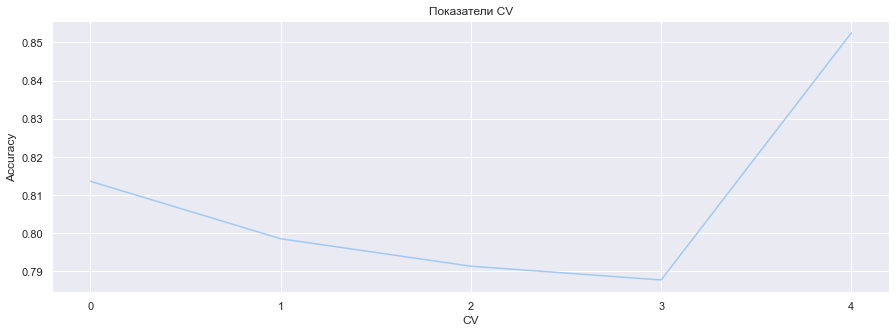

In [69]:
cross_val_plot(model_lr, features_test, target_test)

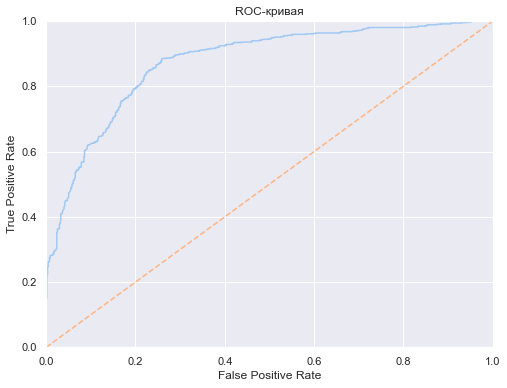

Accuracy: 0.806
F1: 0.815
ROC_auc: 0.805
Precision: 0.801
Recall: 0.83


In [70]:
results(model_lr, features_test, target_test)

In [71]:
prediction_lr = model_lr.predict(features_to_submit)

In [72]:
output = pd.DataFrame({'PassengerId' : test.passenger_id, 'Transported' : prediction_rf})
output.Transported = output.Transported.astype('bool')
output = output.sort_values(by='PassengerId')
#output.to_csv('prediction_rf.csv', index=False)

In [73]:
output

,PassengerId,Transported
840,0005_01,False
1104,0006_02,True
166,0012_01,True
1286,0020_03,True
158,0024_01,True
...,...,...
1318,9244_01,True
1196,9247_01,True
168,9253_01,True
1150,9261_01,True


In [74]:
sample_submission

,PassengerId,Transported
0,0005_01,True
1,0006_02,True
2,0012_01,True
3,0020_03,True
4,0024_01,False
...,...,...
1734,9244_01,False
1735,9247_01,False
1736,9253_01,True
1737,9261_01,True


Самые адекватные модели:
- Random Forest
- Gradient Boosting
- Linear Regression